In [38]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab.grid import RasterModelGrid
from landlab.components import OverlandFlow, SinkFiller
from landlab.components import CRESTHH
import matplotlib.pyplot as plt
from landlab.io import read_geotif
from landlab.grid.mappers import map_mean_of_link_nodes_to_link

In [4]:
basin_shp= gpd.read_file('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/subbasins/08076700.shp',
                         crs='EPSG:4326')
basin_shp= basin_shp.set_crs('EPSG:4326')
basin_shp= basin_shp.to_crs('EPSG:32215')

In [5]:
dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/CRM_Houston_NAm83/DEM_100m.tif')
dem_region= dem_region.rio.write_crs('EPSG:4326')
dem_region= dem_region.rio.reproject('EPSG:32215')

In [6]:
basin_dem= dem_region.rio.clip(basin_shp.geometry, basin_shp.crs).squeeze().sortby('y', ascending=True)

In [7]:
basin= RasterModelGrid(shape= basin_dem.squeeze().shape,
                       xy_spacing=np.diff(basin_dem.x.values)[0],
                       xy_of_lower_left= [basin_dem.x.values[0], basin_dem.y.values[0]]
                      )
basin.axis_units = ('m', 'm')

In [12]:
z= basin.add_field('topographic__elevation', basin_dem.values.astype(float), at="node", clobber=True, dtype=float)


In [13]:
sf= SinkFiller(basin, routing='D4')
sf.fill_pits()

In [14]:
def load_param(path, lons=basin_dem.x.values, lats=basin_dem.y.values):
    param= rioxarray.open_rasterio(path)
    param= param.rio.write_crs('EPSG:4326').rio.reproject('EPSG:32215')
    param= param.sel(x= lons, y=lats, method='nearest')
    return param.values
    

In [15]:
from landlab import imshow_grid_at_node

In [39]:
basin.status_at_node[basin.nodes_at_bottom_edge] = basin.BC_NODE_IS_FIXED_VALUE
basin.status_at_node[np.isclose(z, basin_dem._FillValue)] = basin.BC_NODE_IS_CLOSED
# basin.set_watershed_boundary_condition(z, nodata_value = basin_dem._FillValue)
basin.set_watershed_boundary_condition_outlet_id(8954, 'topographic__elevation')

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


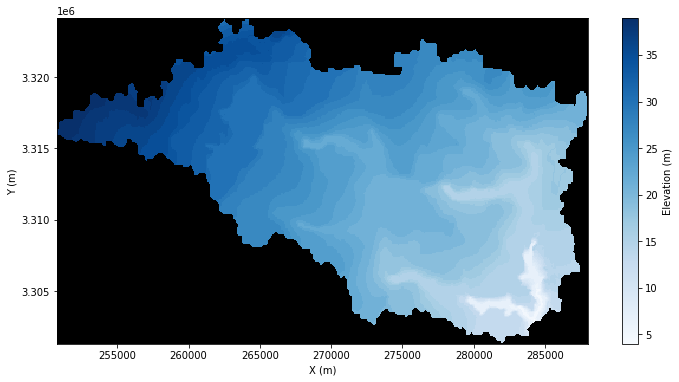

In [31]:
fig= plt.figure(figsize=(12,6))

imshow_grid_at_node(basin, z, colorbar_label='Elevation (m)', cmap='Blues')
plt.show();

In [18]:
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/b_10m.tif')
_= basin.add_field('B', param, at="node", dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/wm_10m.tif')
_= basin.add_field('WM', param, at="node", units='mm',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/ksat.tif')
_= basin.add_field('Ksat', param, at="node", units='mm/hr',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/im.tif')
_= basin.add_field('IM', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/sm.20170826.120000.tif')
_= basin.add_field('SM0', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/friction/manningn.tif')
_= basin.add_field('friction_node', param, at="node",clobber=True, dtype=np.float32)
friction_link= map_mean_of_link_nodes_to_link(basin, 'friction_node')
_= basin.add_field('friction', friction_link.astype(np.float32), at="link",clobber=True, units='-')
_= basin.add_ones('KE',at='node', dtype= np.float32,clobber=True)

In [40]:
cresthh= CRESTHH(basin, proj='EPSG:32215',
                start= '20170826110000',
                end= '20170830000000',
                freq= '1H',
                precip_path='/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/mrms201708/',
                precip_freq='10T',
                precip_pattern='PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif',
                evap_path= '/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/evap/',
                evap_freq='1D',
                evap_pattern= 'cov_et%y%m%d.asc.tif',
                outlet= 8954,
                parallel=4)


In [41]:
cresthh.run()

time: 2017-08-25 11:13:31.853781
----------------------------
elapsed time: 0.23hrs
time step: 811.85
outlet depth: 0.00
SM: 99.7%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 11:27:42.540252
----------------------------
elapsed time: 0.46hrs
time step: 850.69
outlet depth: 0.00
SM: 99.5%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 11:36:21.168389
----------------------------
elapsed time: 0.61hrs
time step: 518.63
outlet depth: 0.00
SM: 99.3%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 11:45:04.483882
----------------------------
elapsed time: 0.75hrs
time step: 523.32
outlet depth: 0.00
SM: 99.0%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 12:04:45.984727
----------------------------
elapsed time: 1.08hrs
time step: 617.07
outlet depth: 0.00
SM: 98.5%
water surface gradient: 0.10
discharge: 0.00
-----------------------


time: 2017-08-25 21:30:24.276126
----------------------------
elapsed time: 10.51hrs
time step: 143.76
outlet depth: 0.00
SM: 77.5%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 21:45:00.831629
----------------------------
elapsed time: 10.75hrs
time step: 147.76
outlet depth: 0.00
SM: 76.4%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 22:02:28.174014
----------------------------
elapsed time: 11.04hrs
time step: 150.48
outlet depth: 0.00
SM: 75.3%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 22:15:08.510354
----------------------------
elapsed time: 11.25hrs
time step: 153.46
outlet depth: 0.00
SM: 74.8%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-25 22:30:46.584602
----------------------------
elapsed time: 11.51hrs
time step: 158.47
outlet depth: 0.00
SM: 74.2%
water surface gradient: 0.10
discharge: 0.00
-------------------

time: 2017-08-26 09:31:44.527977
----------------------------
elapsed time: 22.53hrs
time step: 117.07
outlet depth: 0.00
SM: 66.8%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-26 09:45:13.180126
----------------------------
elapsed time: 22.75hrs
time step: 115.41
outlet depth: 0.00
SM: 67.9%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-26 10:00:37.330589
----------------------------
elapsed time: 23.01hrs
time step: 100.31
outlet depth: 0.00
SM: 69.0%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-26 10:15:53.103136
----------------------------
elapsed time: 23.26hrs
time step: 82.03
outlet depth: 0.00
SM: 70.1%
water surface gradient: 0.10
discharge: 0.00
-----------------------
time: 2017-08-26 10:30:57.158033
----------------------------
elapsed time: 23.52hrs
time step: 82.68
outlet depth: 0.00
SM: 71.0%
water surface gradient: 0.10
discharge: 0.00
---------------------

time: 2017-08-26 19:45:15.477762
----------------------------
elapsed time: 32.75hrs
time step: 16.64
outlet depth: 0.03
SM: 96.0%
water surface gradient: 0.09
discharge: 9.43
-----------------------
time: 2017-08-26 20:00:01.090739
----------------------------
elapsed time: 33.00hrs
time step: 16.79
outlet depth: 0.03
SM: 95.7%
water surface gradient: 0.09
discharge: 10.63
-----------------------
time: 2017-08-26 20:15:07.284973
----------------------------
elapsed time: 33.25hrs
time step: 16.79
outlet depth: 0.03
SM: 95.4%
water surface gradient: 0.09
discharge: 8.95
-----------------------
time: 2017-08-26 20:30:01.088910
----------------------------
elapsed time: 33.50hrs
time step: 16.95
outlet depth: 0.02
SM: 95.1%
water surface gradient: 0.09
discharge: 10.28
-----------------------
time: 2017-08-26 20:45:15.943664
----------------------------
elapsed time: 33.75hrs
time step: 16.95
outlet depth: 0.02
SM: 94.6%
water surface gradient: 0.09
discharge: 8.48
----------------------

time: 2017-08-27 06:00:00.363548
----------------------------
elapsed time: 43.00hrs
time step: 14.12
outlet depth: 0.12
SM: 99.4%
water surface gradient: 0.09
discharge: 27.92
-----------------------
time: 2017-08-27 06:15:10.225533
----------------------------
elapsed time: 43.25hrs
time step: 13.89
outlet depth: 0.13
SM: 99.4%
water surface gradient: 0.09
discharge: 31.33
-----------------------
time: 2017-08-27 06:30:06.093448
----------------------------
elapsed time: 43.50hrs
time step: 13.69
outlet depth: 0.14
SM: 99.5%
water surface gradient: 0.09
discharge: 28.96
-----------------------
time: 2017-08-27 06:45:03.118493
----------------------------
elapsed time: 43.75hrs
time step: 13.51
outlet depth: 0.15
SM: 99.5%
water surface gradient: 0.09
discharge: 34.09
-----------------------
time: 2017-08-27 07:00:04.946252
----------------------------
elapsed time: 44.00hrs
time step: 13.41
outlet depth: 0.15
SM: 99.6%
water surface gradient: 0.09
discharge: 32.67
-------------------

time: 2017-08-27 16:15:01.551866
----------------------------
elapsed time: 53.25hrs
time step: 10.56
outlet depth: 0.21
SM: 99.7%
water surface gradient: 0.08
discharge: 104.01
-----------------------
time: 2017-08-27 16:30:07.918371
----------------------------
elapsed time: 53.50hrs
time step: 10.53
outlet depth: 0.21
SM: 99.7%
water surface gradient: 0.08
discharge: 106.53
-----------------------
time: 2017-08-27 16:45:01.110084
----------------------------
elapsed time: 53.75hrs
time step: 10.50
outlet depth: 0.21
SM: 99.7%
water surface gradient: 0.08
discharge: 108.03
-----------------------
time: 2017-08-27 17:00:02.069971
----------------------------
elapsed time: 54.00hrs
time step: 10.47
outlet depth: 0.21
SM: 99.7%
water surface gradient: 0.08
discharge: 111.11
-----------------------
time: 2017-08-27 17:15:00.119336
----------------------------
elapsed time: 54.25hrs
time step: 10.42
outlet depth: 0.22
SM: 99.7%
water surface gradient: 0.08
discharge: 115.08
--------------

time: 2017-08-28 02:30:00.195600
----------------------------
elapsed time: 63.50hrs
time step: 8.31
outlet depth: 0.36
SM: 99.7%
water surface gradient: 0.06
discharge: 341.14
-----------------------
time: 2017-08-28 02:45:05.884835
----------------------------
elapsed time: 63.75hrs
time step: 8.38
outlet depth: 0.36
SM: 99.8%
water surface gradient: 0.06
discharge: 335.44
-----------------------
time: 2017-08-28 03:00:01.826364
----------------------------
elapsed time: 64.00hrs
time step: 8.06
outlet depth: 0.36
SM: 99.8%
water surface gradient: 0.06
discharge: 345.24
-----------------------
time: 2017-08-28 03:15:03.335193
----------------------------
elapsed time: 64.25hrs
time step: 9.17
outlet depth: 0.36
SM: 99.8%
water surface gradient: 0.06
discharge: 339.58
-----------------------
time: 2017-08-28 03:30:03.105230
----------------------------
elapsed time: 64.50hrs
time step: 8.08
outlet depth: 0.35
SM: 99.7%
water surface gradient: 0.06
discharge: 350.53
-------------------

time: 2017-08-28 12:45:04.354874
----------------------------
elapsed time: 73.75hrs
time step: 8.74
outlet depth: 0.34
SM: 99.4%
water surface gradient: 0.05
discharge: 489.59
-----------------------
time: 2017-08-28 13:00:05.588537
----------------------------
elapsed time: 74.00hrs
time step: 7.76
outlet depth: 0.34
SM: 99.4%
water surface gradient: 0.05
discharge: 510.19
-----------------------
time: 2017-08-28 13:15:03.198641
----------------------------
elapsed time: 74.25hrs
time step: 8.12
outlet depth: 0.34
SM: 99.4%
water surface gradient: 0.05
discharge: 489.13
-----------------------
time: 2017-08-28 13:30:01.711342
----------------------------
elapsed time: 74.50hrs
time step: 8.15
outlet depth: 0.33
SM: 99.4%
water surface gradient: 0.05
discharge: 511.23
-----------------------
time: 2017-08-28 13:45:06.143015
----------------------------
elapsed time: 74.75hrs
time step: 7.70
outlet depth: 0.33
SM: 99.4%
water surface gradient: 0.05
discharge: 492.01
-------------------

time: 2017-08-28 23:00:02.065888
----------------------------
elapsed time: 84.00hrs
time step: 8.73
outlet depth: 0.30
SM: 99.7%
water surface gradient: 0.05
discharge: 524.88
-----------------------
time: 2017-08-28 23:15:01.008044
----------------------------
elapsed time: 84.25hrs
time step: 8.74
outlet depth: 0.30
SM: 99.7%
water surface gradient: 0.05
discharge: 509.40
-----------------------
time: 2017-08-28 23:30:08.644502
----------------------------
elapsed time: 84.50hrs
time step: 8.72
outlet depth: 0.30
SM: 99.7%
water surface gradient: 0.05
discharge: 527.47
-----------------------
time: 2017-08-28 23:45:07.492065
----------------------------
elapsed time: 84.75hrs
time step: 8.74
outlet depth: 0.30
SM: 99.7%
water surface gradient: 0.05
discharge: 505.98
-----------------------
time: 2017-08-29 00:00:06.364325
----------------------------
elapsed time: 85.00hrs
time step: 8.72
outlet depth: 0.30
SM: 99.7%
water surface gradient: 0.05
discharge: 525.19
-------------------

time: 2017-08-29 09:15:02.365634
----------------------------
elapsed time: 94.25hrs
time step: 8.86
outlet depth: 0.28
SM: 99.7%
water surface gradient: 0.05
discharge: 451.10
-----------------------
time: 2017-08-29 09:30:04.674843
----------------------------
elapsed time: 94.50hrs
time step: 8.84
outlet depth: 0.28
SM: 99.7%
water surface gradient: 0.05
discharge: 466.90
-----------------------
time: 2017-08-29 09:45:07.102385
----------------------------
elapsed time: 94.75hrs
time step: 8.86
outlet depth: 0.28
SM: 99.7%
water surface gradient: 0.05
discharge: 449.13
-----------------------
time: 2017-08-29 10:00:01.090826
----------------------------
elapsed time: 95.00hrs
time step: 8.85
outlet depth: 0.28
SM: 99.7%
water surface gradient: 0.05
discharge: 461.50
-----------------------
time: 2017-08-29 10:15:04.359622
----------------------------
elapsed time: 95.25hrs
time step: 8.87
outlet depth: 0.28
SM: 99.7%
water surface gradient: 0.05
discharge: 445.84
-------------------

time: 2017-08-29 19:30:05.173093
----------------------------
elapsed time: 104.50hrs
time step: 9.21
outlet depth: 0.20
SM: 94.6%
water surface gradient: 0.06
discharge: 342.91
-----------------------
time: 2017-08-29 19:45:08.984511
----------------------------
elapsed time: 104.75hrs
time step: 9.24
outlet depth: 0.20
SM: 94.3%
water surface gradient: 0.06
discharge: 329.96
-----------------------
time: 2017-08-29 20:00:04.920282
----------------------------
elapsed time: 105.00hrs
time step: 9.24
outlet depth: 0.20
SM: 94.2%
water surface gradient: 0.06
discharge: 335.51
-----------------------
time: 2017-08-29 20:15:02.190782
----------------------------
elapsed time: 105.25hrs
time step: 9.27
outlet depth: 0.20
SM: 94.0%
water surface gradient: 0.06
discharge: 323.41
-----------------------
time: 2017-08-29 20:30:00.818231
----------------------------
elapsed time: 105.50hrs
time step: 9.27
outlet depth: 0.19
SM: 93.8%
water surface gradient: 0.06
discharge: 328.00
--------------

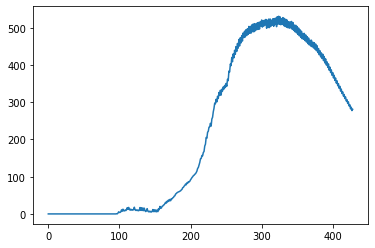

In [49]:
plt.plot(cresthh.outlet['Q'])

In [149]:
basin.at_node['surface_water__depth']

array([ 0.00037   ,  0.00037   ,  0.00037   , ...,  0.00037   ,
        0.00037   ,  0.00081904], dtype=float32)

In [153]:
basin.at_node['surface_water__depth'][:].max()

nan

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


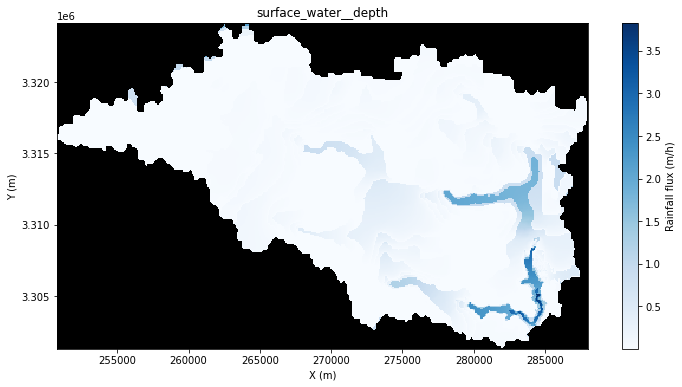

In [51]:
fig= plt.figure(figsize=(12,6))
imshow_grid_at_node(
        basin, 'surface_water__depth', cmap='Blues', colorbar_label='Rainfall flux (m/h)'
    )

In [199]:
pd.Timedelta('1D').total_seconds()

86400.0

In [170]:
from datetime import datetime

In [175]:
(pd.to_datetime('20170825000000') - pd.to_datetime('19700101000000')).total_seconds()

1503619200.0